In [1]:
from jax import jit, vmap, random
import jax.numpy as np
import numpy as onp
import jax

# enable float 64
from jax.config import config
config.update('jax_enable_x64', True)

In [2]:
import pandas as pd
import datetime

def create_df_response(samples, time,  quantiles = [50, 80, 95], forecast_horizon=27, date_init=None, sample_freq="D", dates=None, use_future=False):
    """ Create a dataframe with the quantiles of the model and forecast if provided

    Args:
        samples: Samples of the variable to create the dataframe
        time:    [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """

    if samples.shape[-1] != time:
        raise Exception("Samples second dimension must be equal to time")

    if dates is not None:
        dates_fitted = dates
    elif date_init is not None and sample_freq is not None:
        dates_fitted = pd.date_range(pd.to_datetime(date_init), periods=time, freq=sample_freq)

    else:
        dates_fitted   = list(range(time))
        dates_forecast = list(range(time, time+forecast_horizon))

    dates = dates_fitted
    types = ['estimate']*len(dates_fitted)

    if use_future:
        dates += list(dates_forecast)
        types += ['forecast']*len(dates_forecast)

    results_df  = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)

    # Calculate key statistics
    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q
        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'

    return df_response



In [3]:
# https://github.com/google/jax/issues/10144
def transition(xi, τ, dt=1):
    kb    = np.maximum(1.0 - np.exp(-τ*dt), 0)
    pop   = onp.random.binomial(onp.int64(xi), kb )
    return jax.device_put(pop)

def checkpopvars(x, pop):
    return np.minimum(np.maximum(x, 0), pop)

def sir(x, dt, β, γ, N):
    """ SIR model

    Args:
        x[t]:  State space at time t.
        dt:    Recovery rate.
        β:     Contact rate.
        γ:     Recovery rate.
        N:     Population size.

    Returns:
        x[t+1]: State space at time t+1.
    """

    S = x.at[0, :].get()
    I = x.at[1, :].get()
    R = x.at[2, :].get()
    C = x.at[3, :].get()

    s2i = transition(S, β * I / N, dt)
    i2r = transition(I, γ, dt)

    S  = S - s2i
    I  = I + s2i - i2r
    R  = R + i2r
    C  = s2i

    return checkpopvars(np.array([S, I, R, C]), N)


In [4]:
N = 1000

β = 0.3 # days
γ = 1/7 # days

# initial conditions
I0 = N * 0.01
S0 = N - I0
R0 = 0
C0 = 0

ens = 500
x0  = np.ones((4, ens)) * np.expand_dims(np.array([S0, I0, R0, C0]), -1)

T  = 120
dt = 1

x_sim = x0

x_sim = np.full((4, T, ens), np.nan)
x_sim = x_sim.at[:, 0, :].set(x0)

for t in range(1, T):
    x     = sir(x_sim.at[:, t-1, :].get(), 1, β, γ, N)
    x_sim = x_sim.at[:, t, :].set(x)


In [5]:
S =  x_sim.at[0, :, :].get(); S_df = create_df_response(S.T, T)
I =  x_sim.at[1, :, :].get(); I_df = create_df_response(I.T, T)
R =  x_sim.at[2, :, :].get(); R_df = create_df_response(R.T, T)
C =  x_sim.at[3, :, :].get(); C_df = create_df_response(C.T, T)


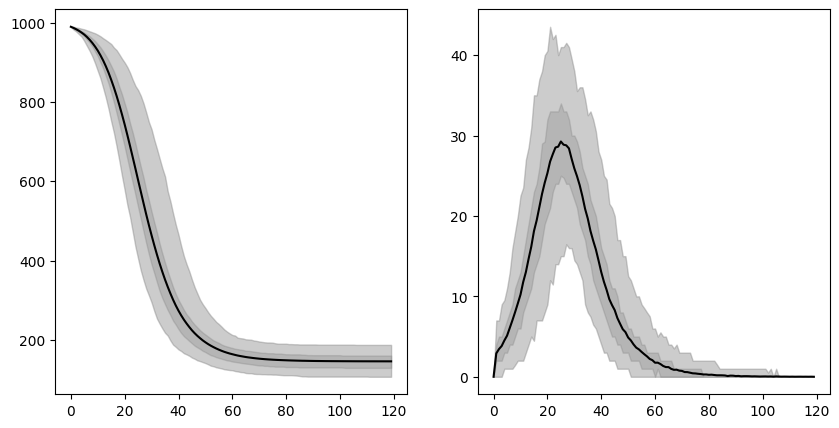

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(S_df.index, S_df['mean'], label='S', color="k")
ax[0].fill_between(S_df.index, S_df['low_95'], S_df['high_95'], alpha=0.4, color="gray")
ax[0].fill_between(S_df.index, S_df['low_50'], S_df['high_50'], alpha=0.3, color="gray")

ax[1].plot(C_df.index, C_df['mean'], label='S', color="k")
ax[1].fill_between(C_df.index, C_df['low_95'], C_df['high_95'], alpha=0.4, color="gray")
ax[1].fill_between(C_df.index, C_df['low_50'], C_df['high_50'], alpha=0.3, color="gray")

In [11]:
def eakf(x, y_sim, y, oev, return_gain=False):
    """ Ensemble Adjustment Kalman Filter

    Args:
        x    : State space at time t.
        y_sim: Simulated observation.
        y    : Measured observation.
        oev  : Observation error variance.
        return_gain (bool, optional): If true return the gain of the filter. Defaults to False.

    Returns:
        xpost: Posterior estimate of state space.
        obspost: Posterior estimate of observation.
    """
    num_vars, num_ens = x.shape
    prior_mean_ct     = y_sim.mean(-1, keepdims=True)  # Average over ensemble members
    prior_var_ct      = y_sim.var(-1, keepdims=True)   # Compute variance over ensemble members

    post_var_ct   = prior_var_ct * oev / (prior_var_ct + oev)
    post_mean_ct  = post_var_ct * (prior_mean_ct/prior_var_ct + y / oev)
    alpha         = oev / (oev+prior_var_ct); alpha = alpha**0.5
    dy            = post_mean_ct + alpha*( y_sim - prior_mean_ct ) - y_sim

    A       = np.cov(x, y_sim)
    covars  = A.at[:-1, -1].get()
    rr      = covars / prior_var_ct
    dx      = np.dot( np.expand_dims(rr, -1), np.expand_dims(dy, 0))
    xpost   = x     + dx
    obspost = y_sim + dy

    if return_gain:
        return xpost, obspost, dx
    else:
        return xpost, obspost

def geometric_cooling(if_iters, cooling_factor=0.9):
    alphas = cooling_factor**np.arange(if_iters)
    return alphas**2

def hyperbolic_cooling(if_iters, cooling_factor=0.9):
    alphas = 1/(1+cooling_factor*np.arange(if_iters))
    return alphas

def cooling(num_iteration_if, type_cool="geometric", cooling_factor=0.9):
    if type_cool=="geometric":
        return geometric_cooling(num_iteration_if, cooling_factor=cooling_factor)
    elif type_cool=="hyperbolic":
        return hyperbolic_cooling(num_iteration_if, cooling_factor=cooling_factor)

def sample_params_uniform(params_range, num_ensembles=100):
    param_ens_prior = []
    for p in params_range.keys():
        param_ens_prior.append( np.random.uniform( params_range[p][0], params_range[p][1]  , size=num_ensembles) )
    return np.array( param_ens_prior )

def sample_params_triangular(params_range, truth_dict, num_ensembles=100):
    param_ens_prior = []
    for p in params_range.keys():
        loww = params_range[p][0]
        upp  = params_range[p][1]
        param_ens_prior.append(  np.random.triangular(loww, np.minimum( truth_dict[p] + np.abs(np.random.rand())*(upp-loww)/2, upp) , upp,  size=num_ensembles) )
    return np.array( param_ens_prior )

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm( (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd )

def sample_params_normal(params_range, params_mean, params_var, num_ensembles=300):
    param_ens_prior = []
    for idx_p, p in enumerate(params_range.keys()):
        norm_gen = get_truncated_normal(mean=params_mean[idx_p], sd=params_var[idx_p]**(1/2), low=params_range[p][0], upp=params_range[p][1])
        param_ens_prior.append( norm_gen.rvs(num_ensembles) )
    return np.array( param_ens_prior )


In [ ]:
from tqdm import tqdm

def if2_eakf(model, param_prior_dict, if2_settings):

    obs_w_df           = df_obs.set_index("date").resample("W-Sun").sum()
    obs_w_df           = obs_w_df[["positives"]].rename(columns={"positives": "confirmed"})
    oev_df             = pd.DataFrame(columns=["date", "oev"])
    oev_df["date"]     = obs_w_df.index.values
    oev_df             = oev_df.set_index("date")
    oev_df["oev"]      = 1 + (0.2*obs_w_df["confirmed"].values)**(2)
    obs_w_df["oev"]    = oev_df["oev"].values

    ################ INFERENCE  SETTINGS ################
    # Range of parameters
    cooling_factor   = cooling(if2_settings["num_iters"], type_cool=if2_settings["type_cooling"], cooling_factor=if2_settings["alpha_mif"])

    param_range      = np.array([v for k, v in param_prior_dict.items()])
    std_param        = param_range[:,1] - param_range[:,0]
    SIG              = std_param ** 2 / 4; #  initial covariance of parameters

    # Perturbation is proportional to the prior range of search.
    perturbation       = np.array([ list( std_param/4 )]).T
    num_steps          = len(obs_w_df) #387
    para_post_all      = np.zeros((if2_settings["num_params"], if2_settings["num_ensembles"], num_steps, if2_settings["num_iters"]))
    theta              = np.zeros((if2_settings["num_params"], if2_settings["num_iters"]+1))

    confirmed_post_all = np.zeros((1, if2_settings["num_ensembles"], num_steps, if2_settings["num_iters"]))

    para_post_all      = np.zeros((if2_settings["num_params"], if2_settings["num_ensembles"], num_steps, if2_settings["num_iters"]))
    x_post_all         = np.zeros((5, if2_settings["num_ensembles"], num_steps, if2_settings["num_iters"]))

    theta              = np.zeros((if2_settings["num_params"], if2_settings["num_iters"]+1))

    dates_assimilation = obs_w_df.index.get_level_values(0).values


    for n in tqdm(range(if2_settings["num_iters"])):
        if n==0:
            p_prior     = sample_params_uniform(param_prior_dict, num_ensembles=if2_settings["num_ensembles"])
            beta        = p_prior[0,:]
            gamma       = p_prior[1,:]
            alpha       = p_prior[2,:]

            x           = np.expand_dims(np.array([initial_admitted, 0, 0, 0, 0]), -1) * np.ones((5, if2_settings["num_ensembles"]))
            x[0, :]     = x[0, :] * gamma
            theta[:, n] = np.mean(p_prior, -1)

        else:
            params_mean     = theta[:,n]
            params_var      = SIG * (if2_settings["alpha_mif"]**n)**2
            p_prior         = sample_params_normal(param_prior_dict, params_mean, params_var, num_ensembles=if2_settings["num_ensembles"])

            gamma           = p_prior[1,:]

            x           = np.expand_dims(np.array([initial_admitted, 0, 0, 0, 0]), -1) * np.ones((5, if2_settings["num_ensembles"]))
            x[0, :]     = x[0, :] * gamma

        param_post_time   = np.zeros((len(param_prior_dict), if2_settings["num_ensembles"], num_steps))
        x_post_time       = np.zeros((5, if2_settings["num_ensembles"], num_steps))
        obs_post_time     = np.zeros((1, if2_settings["num_ensembles"], num_steps))

        idx_date_update = 0


        confirmed_t = np.zeros((if2_settings["num_ensembles"], 1))

        for idx_t, date in enumerate(dates):
            #print(idx_t)
            beta   = p_prior[0, :] # contact rate
            gamma  = p_prior[1, :] # importation probability
            alpha  = p_prior[2, :] # detection rate

            x_ens = model(x, params_dict["sigma"], gamma, Ni, admissions_df.loc[date], beta, params_dict["lambda"], alpha)
            x     = x_ens

            confirmed_t  +=  np.expand_dims(x[-1,:], -1)


            if pd.to_datetime(date) == pd.to_datetime(dates_assimilation[idx_date_update]):
                # Perturb parameters according to the define mapping
                if if2_settings["perturb_time"]:
                    # Transform parameters for perturbation
                    std_params = perturbation*cooling_factor[n]
                    p_prior    = random_walk_perturbation(p_prior, std_params, if2_settings["num_params"], if2_settings["num_ensembles"])

                ## inflate state variables
                #x = inflate_ensembles(x, inflation_value=if2_settings["lambda_inf"], num_ensembles=if2_settings["num_ensembles"])
                #x = np.maximum(x, 0)

                # Inflate parameters
                p_prior = inflate_ensembles(p_prior, inflation_value=if2_settings["lambda_inf"], num_ensembles=if2_settings["num_ensembles"])
                p_prior = checkbound_params(param_prior_dict, p_prior, num_ensembles=if2_settings["num_ensembles"])

                oev_confirmed_time   = obs_w_df.loc[date]["oev"]
                confirmed_time       = obs_w_df.loc[date]["confirmed"]

                param_post           = p_prior.copy()

                # Update parameters using confirmed deaths
                x_post, param_post, confirmed_obs_post = eakf_step(x, param_post, np.squeeze(confirmed_t), confirmed_time, oev_confirmed_time, param_prior_dict, num_var=5)
                param_post                             = checkbound_params(param_prior_dict, params_ens=param_post, num_ensembles=if2_settings["num_ensembles"])
                x =  x_post.copy()
                x = np.maximum(x, 0)

                # Use posterior as next prior
                p_prior                               = param_post.copy()
                param_post_time[:,:,idx_date_update]  = param_post
                obs_post_time[:,:,idx_date_update]    = confirmed_obs_post

                idx_date_update += 1
                confirmed_t     =  np.zeros((if2_settings["num_ensembles"], 1))

        confirmed_post_all[:,:,:,n] = obs_post_time
        para_post_all[:,:,:,n]      = param_post_time
        x_post_all[:,:,:,n]         = x_post_time
        theta[:,n+1]                = param_post_time.mean(-1).mean(-1)

    return confirmed_post_all, para_post_all, x_post_all, theta, df_obs